In [1]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import find_peaks
from scipy.optimize import curve_fit

plt.style.use('seaborn-v0_8')
plt.rcParams['legend.framealpha'] = 1  ## disable any default legend frame transparency from the style

In [18]:
# ------------------------------- all datasets ------------------------------- #
dirpath_data = Path('/home/lain/root/100_work/110_projects/111_mars/code-repos/redplanet/scrap/250408_modlab_nmr/exp_modern_phys_388/nmr/nmr_data')

metadata = {
    'purcell-seq-2': {
        'fname': 'carr-purcell-sequence-2.csv',
        'cols': [9, 10],
        # 'x_scale': 0.02499999937,
        # 'y_scale': 5.00000007,
        # 'x_bounds': [-0.0004, 0.00044],
        # 'x_bounds': [-0.01, 0.17],
        'find_peak_params': {
            'distance': 50,
            'height': 1,
        },
        'curve_fit_guess': (10, 0.001, 1),
    },
    'n=10': {
        'fname': 'carr-purcell-n-10-tau-4ms.csv',
        'cols': [3, 4],
        'find_peak_params': {
            'distance': 50,
            'height': 3,
        },
        'curve_fit_guess': (10, 0.001, 1),
        'idx_peaks2skip': [0],
    },
    'n=20': {
        'fname': 'carr-purcell-n-20-tau-1ms.csv',
        'cols': [3, 4],
        'find_peak_params': {
            'distance': 50,
            'height': 3,
        },
        'curve_fit_guess': (10, 0.001, 1),
        'idx_peaks2skip': [0],
    },
    'n=50': {
        'fname': 'carr-purcell-n-50-tau-900us.csv',
        'cols': [3, 4],
        'find_peak_params': {
            'distance': 25,
            'height': 3,
        },
        'curve_fit_guess': (10, 0.001, 1),
        'idx_peaks2skip': [0],
    }
}



def plot_purcell(choice: str) -> None:

    if choice not in metadata:
        raise ValueError(f'Invalid dataset: {choice}. Options are: {list(metadata.keys())}')

    meta = metadata[choice]

    print(f'Analyzing "{meta["fname"]}"...\n')



    # --------------------------------- load data -------------------------------- #
    fpath = dirpath_data / meta['fname']
    df = pd.read_csv(
        fpath,
        usecols = meta['cols'],
        header = None,
        names = ['t', 'v'],
    )



    # ------------------------------- crop & scale ------------------------------- #

    # df['t'] *= meta['x_scale']
    # df['v'] *= meta['y_scale']

    # df = df[
    #     (df['t'] > meta['x_bounds'][0]) &
    #     (df['t'] < meta['x_bounds'][1])
    # ]



    # ---------------- convert to 1D numpy arrays for convenience ---------------- #
    dat_t = df['t'].to_numpy()
    dat_v = df['v'].to_numpy()



    # -------------------------------- find peaks -------------------------------- #
    idx_peaks = find_peaks(
        dat_v,
        **meta['find_peak_params'],
    )[0]

    idx_peaks2skip = meta.get('idx_peaks2skip', [])
    idx_peaks = np.delete(idx_peaks, idx_peaks2skip)

    dat_t_peaks = dat_t[idx_peaks]
    dat_v_peaks = dat_v[idx_peaks]



    # ------------------------------------ fit ----------------------------------- #
    def exp_decay(t, A, B, C):
        return A * np.exp(-t/B) + C

    popt, pcov = curve_fit(
        exp_decay,
        dat_t_peaks,
        dat_v_peaks,
        p0 = meta['curve_fit_guess'],
    )
    A_fit, B_fit, C_fit = popt
    print(f'Fit: {A_fit = :.3f}, {B_fit = :.3e}, {C_fit = :.3f}\n')

    print(f'* T_2 = {B_fit * 1e3 :.2f} ms\n')


    dat_t_fit = np.linspace(
        dat_t_peaks.min(),
        dat_t_peaks.max(),
        1000,
    )
    dat_v_fit = exp_decay(dat_t_fit, A_fit, B_fit, C_fit)



    # ----------------------------------- plot ----------------------------------- #

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(
        dat_t * 1e3,
        dat_v,
        label = 'Raw Data',
        # alpha = 0.5,
        linewidth = 1,
    )

    ax.scatter(
        dat_t_peaks * 1e3,
        dat_v_peaks,
        label = f'Echo Peaks (Total {len(idx_peaks)})',
        color = 'firebrick',
        s = 10,
    )

    ax.plot(
        dat_t_fit * 1e3,
        dat_v_fit,
        # 'k-',
        label = (
            r'Decay Envelope: $A \cdot \exp (-t/B) + C$'
            # f'\n$\\Longrightarrow$A={A_fit:.2f}, B={B_fit:.2e}, C={C_fit:.2f}',
            f'\n$ \\Longrightarrow (A,B,C)=$({A_fit:.2f}, {B_fit:.2e}, {C_fit:.2f})'
        ),
        linestyle = 'dashed',
    )

    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Voltage [V]')



    t_max = dat_t_peaks.max()
    t_min = dat_t_peaks.min()
    t_diff = t_max - t_min
    padding = 0.1
    # padding = 0.2
    ax.set_xlim(
        (t_min - padding*t_diff) * 1e3,
        (t_max + padding*t_diff) * 1e3,
    )



    legend = ax.legend(
        # loc='lower left',
        frameon=True,
    )
    frame = legend.get_frame()
    frame.set_alpha(None)  ## disable any rcParam alpha override
    frame.set_facecolor((1, 1, 1, 0.1))  ## set frame coloring to white with some transparency
    frame.set_edgecolor('black')

    plt.show()

    return

Analyzing "carr-purcell-sequence-2.csv"...

Fit: A_fit = 15.103, B_fit = 4.470e-02, C_fit = 1.298

* T_2 = 44.70 ms



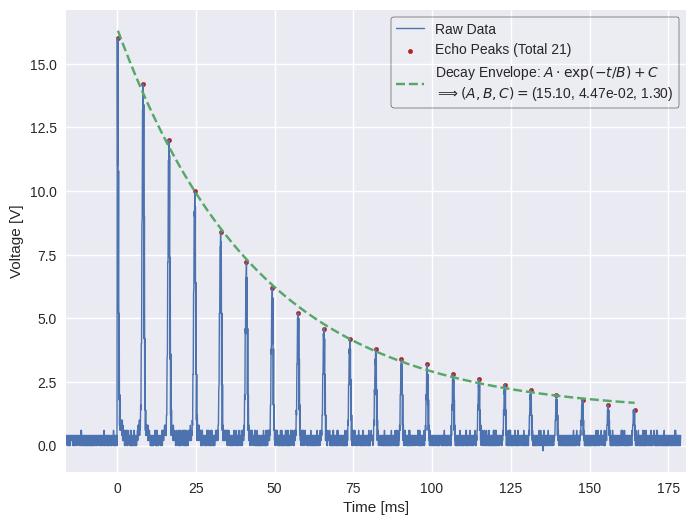

Analyzing "carr-purcell-n-10-tau-4ms.csv"...

Fit: A_fit = 16.536, B_fit = 4.879e-02, C_fit = 0.821

* T_2 = 48.79 ms



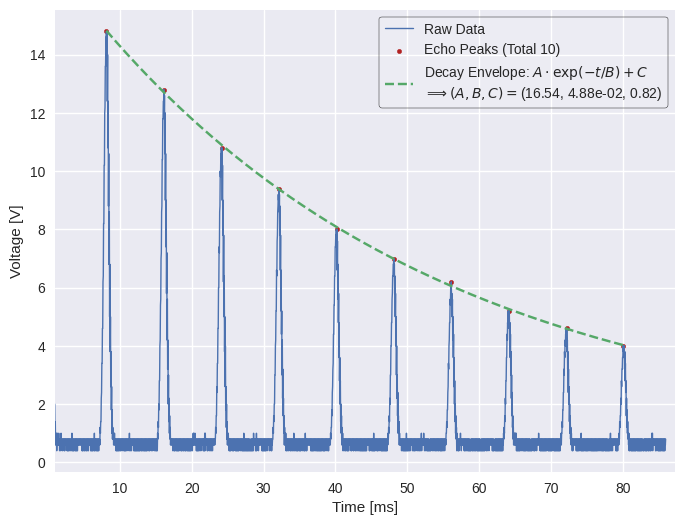

Analyzing "carr-purcell-n-20-tau-1ms.csv"...

Fit: A_fit = 14.706, B_fit = 4.109e-02, C_fit = 2.903

* T_2 = 41.09 ms



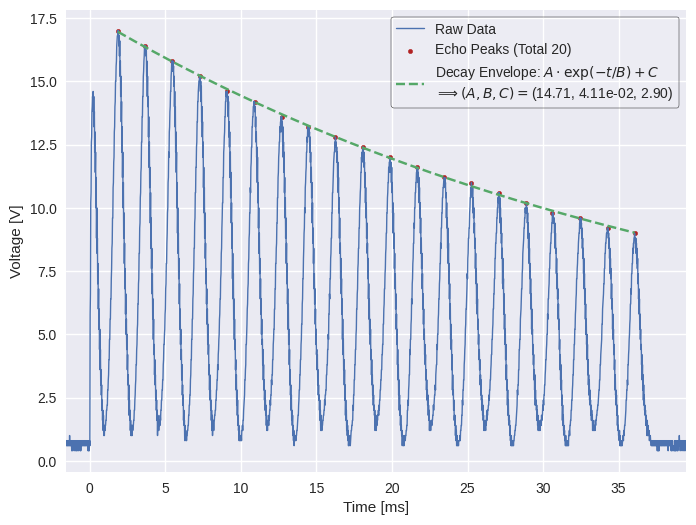

Analyzing "carr-purcell-n-50-tau-900us.csv"...

Fit: A_fit = 14.854, B_fit = 4.133e-02, C_fit = 2.748

* T_2 = 41.33 ms



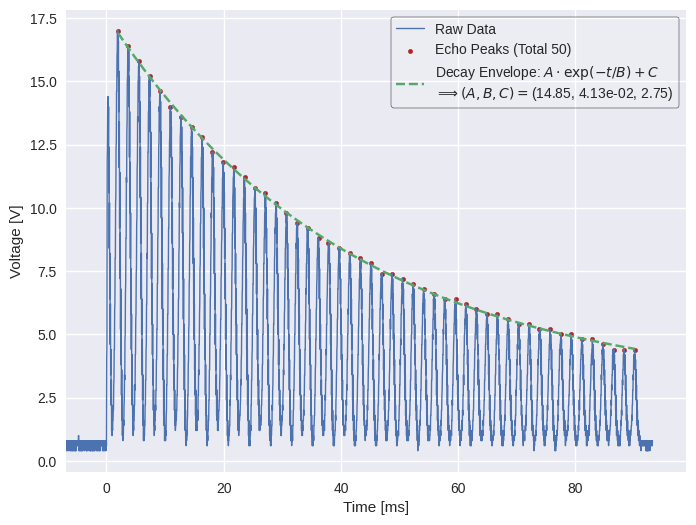

In [19]:
# ----------------------- USER INPUT: choose a dataset ----------------------- #

# choice = 'purcell-seq-2'
# choice = 'n=10'
# choice = 'n=20'
# choice = 'n=50'

for choice in metadata:
    plot_purcell(choice)